In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
!pip install nltk scikit-learn matplotlib scipy -q

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


False

In [4]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### load dataset

In [72]:
dataset = "newsgroup"

# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
all_docs, old_labels, categories = all_docs.data, all_docs.target, all_docs.target_names

In [6]:
# dataset = "bbc"

# data = pd.read_csv('bbcsport.csv')

# all_docs = data["text"].to_list()
# old_labels = data["topic"].to_list()
# categories = classes = np.unique(data["topic"]).tolist()

### clean dataset

In [74]:
datasize = 90
min_document_length = 256
max_document_length = 512


index = -1
docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        label_index = old_labels[index]
            
        if sizes[label_index] == datasize:
            continue
        
        doc = all_docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if not status:
            continue
            
        if min_document_length is not None and len(doc) < min_document_length:
            continue
            
        if max_document_length is not None and len(doc) > max_document_length:
            continue
        
        label_indices.append(label_index)
        labels.append(categories[label_index])
        
        docs.append(doc)
        sizes[label_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [75]:
index = 3
print(f"Topic: {labels[index]}\n{'='*50}\n{docs[index][:512]}")

Topic: sci.space
sorry folk i should have do this and meant to just after i hit the send key orbital element of comet 1977vii from dance file p au 3 424346 e 0 151899 i 1 0988 cap omega 0 243 5652 w 0 231 1607 epoch 1977 04110 also perihelion of gehrels3 be april 1973 83 jupiter radius august 1970 3 jupiter radius hope this help i m even le of an orbital mechanic than i be an artist


In [76]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[90, 90, 90, 90]


## Split data

In [77]:
x_train, x_test, y_train, y_test = train_test_split(docs, labels, test_size =.3)

In [78]:
print(f"there are {len(docs)} total docs, {len(y_train)} train and {len(y_test)} test")

there are 360 total docs, 252 train and 108 test


### Initialize Vectorizer

In [505]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(x_train)

vocabulary = np.array(vectorizer.get_feature_names())
print("word_count is", len(vocabulary))

word_count is 3642


### Prepare Datatset

In [506]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(x_train).toarray()
test_doc_vectors = vectorizer.transform(x_test).toarray()

In [507]:
# reduce freq in doc to bin value of 1 or 0
binary = False

word_freq_in_doc_train = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_freq_in_doc_test = pd.DataFrame(test_doc_vectors, columns=vocabulary)

word_doc_frequency_norm_train = (word_freq_in_doc_train.T / word_freq_in_doc_train.sum(1)).T
word_doc_frequency_norm_test = (word_freq_in_doc_test.T / word_freq_in_doc_test.sum(1)).T

if binary:
    wdf_train = (word_doc_frequency_norm_train > 0).astype(int)
    wdf_test = (word_doc_frequency_norm_test > 0).astype(int)
    
else:    
    wdf_train = word_doc_frequency_norm_train.copy()
    wdf_test = word_doc_frequency_norm_test.copy()

## Word Topic Probability Distr

In [508]:
wdt_train = wdf_train.copy()
wdt_test = wdf_test.copy()

wdt_test["__labels__"] = y_test
wdt_train["__labels__"] = y_train

word_doc_count = wdf_train.sum(0)
topic_doc_count = pd.DataFrame(Counter(y_train), index=[0]).T[0]
word_topic_pr_distr = pd.DataFrame(data=0.0, columns=categories, index=vocabulary)

for category in tqdm(categories):
    pxy = wdf_train[wdt_train["__labels__"] == category].sum(0) / topic_doc_count[category]
    word_topic_pr_distr[category] = pxy * (topic_doc_count[category] / word_doc_count)

print(f"word_topic_pr_distr shape = {word_topic_pr_distr.shape}")


word_topic_pr_distr shape = (3642, 4)


In [509]:
word_topic_pr_distr.head()

,alt.atheism,rec.autos,sci.space,talk.politics.mideast
00,0.000000,0.411765,0.588235,0.000000
000,0.868217,0.000000,0.000000,0.131783
000mi,0.000000,1.000000,0.000000,0.000000
02,0.000000,1.000000,0.000000,0.000000
034101,0.000000,0.000000,1.000000,0.000000


In [510]:
topic_index = 3
topic = categories[topic_index]

print(f"Topwords: Topic - {topic}\n{'='*50}")
word_topic_pr_distr[topic].sort_values(ascending=False).head(10)

Topwords: Topic - talk.politics.mideast


discriminatory    1.0
eece              1.0
2300              1.0
whoever           1.0
tesiel            1.0
affirmative       1.0
finding           1.0
text              1.0
1948              1.0
moron             1.0
Name: talk.politics.mideast, dtype: float64

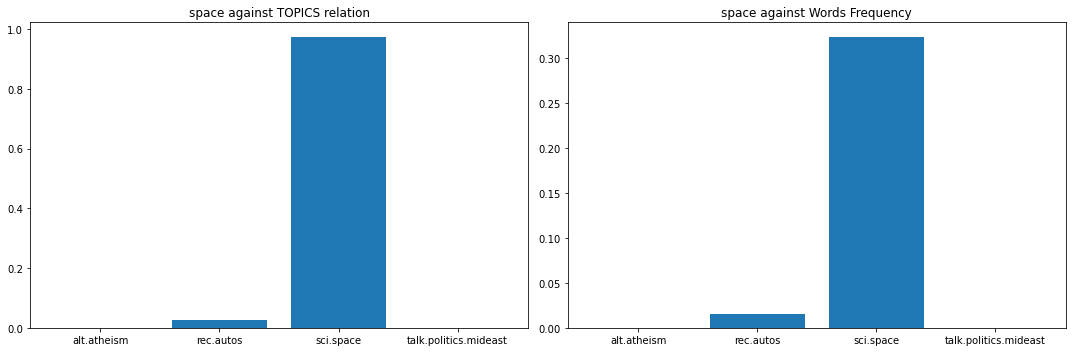

In [511]:
word = "space"

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(121)
ax12 = fig.add_subplot(122)

ax11.set_title(f"{word} against TOPICS relation")
ax11.bar(word_topic_pr_distr.columns, word_topic_pr_distr.loc[word])

word_topic_freq = Counter(wdt_train["__labels__"][wdt_train[word] > 0])
freqs = []
for topic in word_topic_pr_distr.columns:
#     freqs.append(word_topic_freq[topic])
    freqs.append(word_topic_freq[topic] / topic_doc_count[topic])

ax12.set_title(f"{word} against Words Frequency")
ax12.bar(word_topic_pr_distr.columns, freqs)

plt.show()

### Quick Topic Inference

In [512]:
doc_index = 0
num_of_topwords = 8

doc_index = 6
print(f"Document: {doc_index}, Topic: {y_train[doc_index]}\n{'='*50}\n{x_train[doc_index][:512]}\n")

Document: 6, Topic: alt.atheism
no that s pray on the young prey on the young come later when the bright eyed little altar boy find out what the priest really wear under that chasible bob beauchaine bobbe vice ico tek com they say that queen could stay they blew the bronx away and sank manhattan out at sea



In [513]:
doc_vector = wdf_train.loc[doc_index]
doc_word_topic_pr_distr, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)

print(f"Inference: Document {doc_index}\n{'='*50}")
print(f"actual = {wdt_train.loc[doc_index]['__labels__']}, predicted = {predicted_doc_topic}\n")

Inference: Document 6
actual = alt.atheism, predicted = alt.atheism



In [514]:
print(f"Topwords: Document {doc_index}\n{'='*50}")
print(wdf_train.loc[doc_index].sort_values(ascending=False).head(num_of_topwords))

Topwords: Document 6
the      0.094340
that     0.056604
on       0.037736
out      0.037736
they     0.037736
young    0.037736
and      0.018868
boy      0.018868
Name: 6, dtype: float64


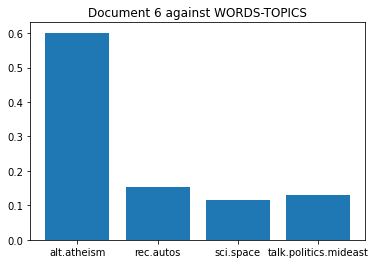

In [515]:
plt.title(f"Document {doc_index} against WORDS-TOPICS")
plt.bar(categories, doc_word_topic_pr_distr.sum(0))
plt.show()

### Topic Word Distr - Train Accuracy

In [516]:
score_train = 0
for doc_index in tqdm(range(len(y_train))):
    doc_vector = wdf_train.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_train.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_train += mark

train_accuracy = score_train * 100 / len(y_train)
print(f"train accuracy = {train_accuracy: .2f}%")


train accuracy =  100.00%


### Topic Word Distr - Test Accuracy

In [517]:
score_test = 0
for doc_index in tqdm(range(len(y_test))):
    doc_vector = wdf_test.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_test.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_test += mark

test_accuracy = score_test * 100 / len(y_test)
print(f"test accuracy = {test_accuracy: .2f}%")


test accuracy =  75.00%


### Overrall Accuracy

In [518]:
overall_accuracy = (train_accuracy + test_accuracy)/2
print(f"overall_accuracy = {overall_accuracy: .2f}%")

overall_accuracy =  87.50%


## Word Word Probability Distr

In [519]:
word_word_pr_distr = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

for word in tqdm(vocabulary):
    pxy = wdf_train[wdf_train[word] > 0].sum(0) / word_doc_count[word]
#     pxy = (wdf_train.T * wdf_train[word]).sum(1)/ word_doc_count[word]
    word_word_pr_distr[word] = pxy * (word_doc_count[word] / word_doc_count)

print(f"word_word_pr_distr shape = {word_word_pr_distr.shape}")


word_word_pr_distr shape = (3642, 3642)


In [520]:
word_word_pr_distr.head()

,00,000,000mi,02,034101,0565,09,10,100,1000,...,yuru,zealand,zeitgeist,zillion,zion,zionism,zionist,zip,zlumber,zu
00,1.0,0.0,0.411765,0.0,0.0,0.0,0.0,0.588235,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000mi,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
034101,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [521]:
word = "space"

print(f"Topwords: Word - {word}\n{'='*50}")
word_word_pr_distr[word].sort_values(ascending=False).head(10)

Topwords: Word - space


ambitious     1.0
moonbase      1.0
energia       1.0
enhance       1.0
teh           1.0
essay         1.0
cheif         1.0
gain          1.0
function      1.0
washington    1.0
Name: space, dtype: float64

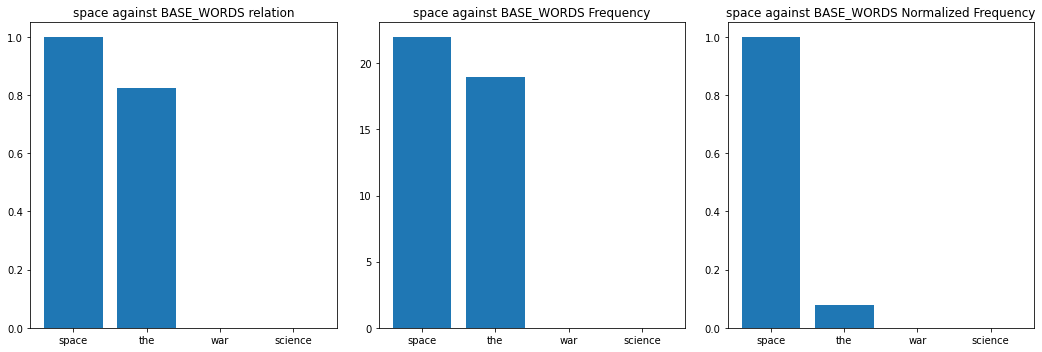

In [541]:
word = "space"
base_words = ["space", "the", "war", "science"]

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(131)
ax12 = fig.add_subplot(132)
ax13 = fig.add_subplot(133)

ax11.set_title(f"{word} against BASE_WORDS relation")
ax11.bar(base_words, word_word_pr_distr.loc[word][base_words])

freqs, norm_freqs = [], []
wdc = (wdt_train[base_words] > 0).sum(0)
word_word_freq = (wdt_train[base_words][wdt_train[word] > 0] > 0).sum(0)

for w in base_words:
    freqs.append(word_word_freq[w])
    norm_freqs.append(word_word_freq[w] / wdc[w])

ax12.set_title(f"{word} against BASE_WORDS Frequency")
ax12.bar(base_words, freqs)

ax13.set_title(f"{word} against BASE_WORDS Normalized Frequency")
ax13.bar(base_words, norm_freqs)

plt.show()

## Trial

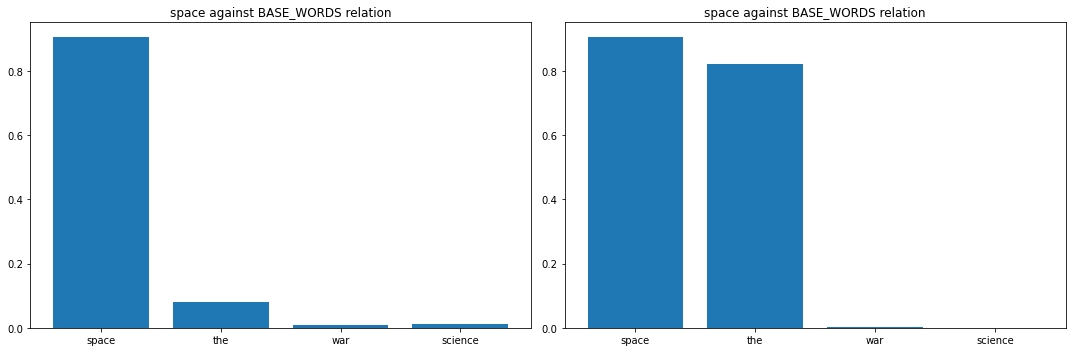

In [724]:
num_of_iterations = 3
word_word_pr_distr_prime = word_word_pr_distr.copy()

for n_iter in tqdm(range(num_of_iterations)):
    word_word_pr_distr_last_prime = word_word_pr_distr_prime.copy()
    word_word_pr_distr_prime = 0 * word_word_pr_distr_last_prime
    
    word_word_pr_entropy = calculate_entropy(word_word_pr_distr_last_prime, axis=1)
    word_word_pr_entropy_softmax = softmax(word_word_pr_entropy.max() - word_word_pr_entropy)
    
    for word in tqdm(vocabulary):
        denom = 0
        indices = (word_word_pr_distr_last_prime[word] > 0)
        
        xv = word_word_pr_distr_last_prime[word][indices]
        entrp_sm = word_word_pr_entropy_softmax[indices]

        for index, (wordx, word_pr) in enumerate(xv.iteritems()):
            gamma = word_pr * entrp_sm[index]

            denom += gamma
            word_word_pr_distr_prime[word] += gamma * word_word_pr_distr_last_prime[wordx]
            
        word_word_pr_distr_prime[word] /= denom
    
    word = "space"
    base_words = ["space", "the", "war", "science"]

    fig = plt.figure(figsize=(15, 5), tight_layout=True)
    ax11 = fig.add_subplot(121)
    ax12 = fig.add_subplot(122)


    ax11.set_title(f"{word} against BASE_WORDS relation")
    ax11.bar(base_words, word_word_pr_distr_prime[word][base_words])

    base_words = ["space", "the", "war", "science"]

    ax12.set_title(f"{word} against BASE_WORDS relation")
    ax12.bar(base_words, word_word_pr_distr_prime.loc[word][base_words])

    plt.show()

In [705]:
w1 = "the"
w2 = "science"
w3 = "space"
# w1 = w2 = w3

word_word_pr_entropy = calculate_entropy(word_word_pr_distr_last_prime, axis=0)
word_word_pr_entropy_softmax = softmax(word_word_pr_entropy.max() - word_word_pr_entropy)

In [706]:
word_word_pr_entropy[vocabulary == w1], word_word_pr_entropy_softmax[vocabulary == w1]

(array([8.15539922]), array([2.63535051e-06]))

In [707]:
word_word_pr_entropy[vocabulary == w2], word_word_pr_entropy_softmax[vocabulary == w2]

(array([2.86734032]), array([0.00052169]))

In [714]:
word_word_pr_distr_prime[w3].sort_values(ascending=False)

ambitious      0.069081
fly            0.069081
reduce         0.069081
alan           0.069081
transporter    0.069081
                 ...   
victim         0.000150
victimize      0.000150
namely         0.000150
deed           0.000150
identify       0.000150
Name: space, Length: 3642, dtype: float64

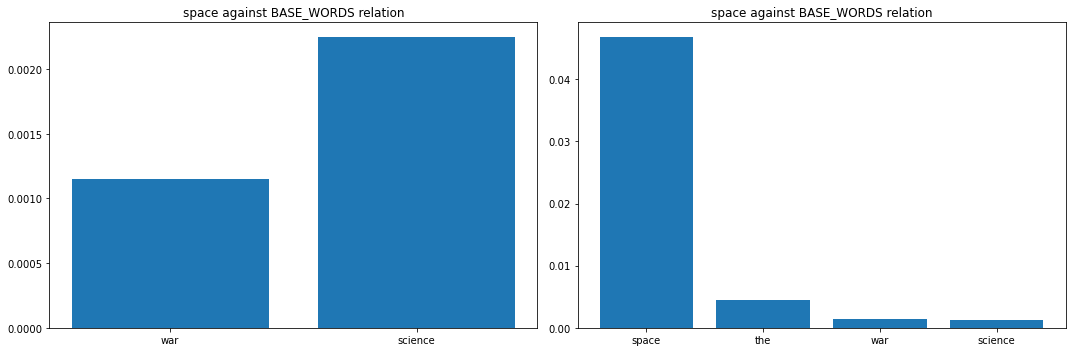

In [720]:
word = "space"
base_words = ["war", "science"]

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(121)
ax12 = fig.add_subplot(122)


ax11.set_title(f"{word} against BASE_WORDS relation")
ax11.bar(base_words, word_word_pr_distr_prime.loc[word][base_words])

base_words = ["space", "the", "war", "science"]

ax12.set_title(f"{word} against BASE_WORDS relation")
ax12.bar(base_words, word_word_pr_distr_prime.loc[word][base_words])

plt.show()